In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pyAudioAnalysis import audioBasicIO #A
from pyAudioAnalysis import ShortTermFeatures #B
import matplotlib.pyplot as plt
import os #C

C:\Users\hlynn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hlynn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hlynn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hlynn\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

오디오 파일 전처리

In [2]:
def preProcess( fileName ):
    [Fs, x] = audioBasicIO.read_audio_file(fileName) #A

    """#B
    if( len( x.shape ) > 1 and  x.shape[1] == 2 ):
        x = np.mean( x, axis = 1, keepdims = True )
    else:
        x = x.reshape( x.shape[0], 1 )"""
    #C
    F, f_names = ShortTermFeatures.feature_extraction(
        x[ :, 0 ],
        Fs, 0.050*Fs,
        0.025*Fs
    )
    
    return F

크로마그램 특성 추출

In [3]:
def getChromagram( audioData ):
    
    # A
    temp_data =  audioData[ 21 ].reshape( 
        1, 
        audioData[ 21 ].shape[0] 
    )
    chronograph = temp_data
    
    # B
    for i in range( 22, 33 ):
        temp_data =  audioData[ i ].reshape( 
            1, 
            audioData[ i ].shape[0] 
        )
        chronograph = np.vstack( [ chronograph,  temp_data ] )
    
    return chronograph

In [4]:
def getNoteFrequency( chromagram ):
    
    numberOfWindows = chromagram.shape[1] #A
    
    freqVal = chromagram.argmax( axis = 0 ) #B
    
    histogram, bin = np.histogram( freqVal, bins = 12 ) #C
    
    normalized_hist = histogram.reshape( 1, 12 ).astype( float ) / numberOfWindows #D
    
    return normalized_hist

In [5]:
fileList = []
def getDataset( filePath ):
    X = pd.DataFrame(  )
    
    columns=[ "G#", "G", "F#", "F", "E", "D#", "D", "C#", "C", "B", "A#", "A" ]
    
    for root, dirs, filenames in os.walk( filePath ):
        for file in filenames:
            fileList.append( file )
            features = preProcess(filePath + file )
            chromagram = getChromagram( features )
            noteFrequency = getNoteFrequency( chromagram )
            x_new =  pd.Series(noteFrequency[ 0, : ])
            X = pd.concat( [ X, x_new ], axis = 1 )
        
    data = X.T.copy()
    data.columns = columns
    data.index = [ i for i in range( 0, data.shape[ 0 ] ) ]
            
    return data

전처리 함수 적용 결과(음악 하나 당 여러개 특성들로 구성)

In [6]:
os.chdir("C:\\ffmpeg\\bin\\input")

In [17]:
import librosa
import IPython.display
x, fs = librosa.load("C:/ffmpeg/bin/input/Ariana Grande - God is a woman(0).wav")
IPython.display.Audio(x, rate=fs)

In [18]:
X = librosa.feature.mfcc(x, sr=fs)
print(X)

[[-5.90371765e+02 -5.79873901e+02 -5.33296021e+02 ... -1.12974548e+02
  -1.08071754e+02 -1.07531143e+02]
 [ 0.00000000e+00  1.20969505e+01  4.82984619e+01 ...  6.57735748e+01
   6.67687149e+01  7.35965195e+01]
 [ 0.00000000e+00  6.61423016e+00  3.99980736e+00 ... -1.74475040e+01
  -2.49852676e+01 -2.48765717e+01]
 ...
 [ 0.00000000e+00 -3.15477109e+00 -1.05742092e+01 ... -3.78648853e+00
   1.78909075e+00 -7.67513454e-01]
 [ 0.00000000e+00 -4.99189943e-01 -4.51813412e+00 ...  1.35409489e+01
   1.71430206e+01  1.40705204e+01]
 [ 0.00000000e+00  3.49931669e+00  5.71236515e+00 ...  4.15235043e+00
   6.65348721e+00  5.70160246e+00]]


In [19]:
pca=PCA(n_components=2,whiten=True)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [20]:
X_pca=pca.fit_transform(X)
X_pca

array([[ 3.7253952 ,  1.9808822 ],
       [-2.0887377 ,  3.2690413 ],
       [ 0.02871663, -0.8482962 ],
       [-0.37730086,  0.69208395],
       [-0.26761   ,  0.14578775],
       [ 0.03815927, -0.07261266],
       [-0.30681974, -0.22605614],
       [ 0.12461972, -0.7876988 ],
       [-0.34082767,  0.12146559],
       [-0.2533697 , -0.45863402],
       [ 0.21116175, -0.5375184 ],
       [-0.23820487,  0.05780395],
       [ 0.13548715, -0.771741  ],
       [ 0.08625271, -0.40342572],
       [-0.00505633, -0.37328947],
       [-0.0221372 , -0.70185685],
       [ 0.09474005, -0.67622435],
       [-0.10171384, -0.3482063 ],
       [-0.16076829, -0.07936274],
       [-0.2819862 ,  0.01785903]], dtype=float32)

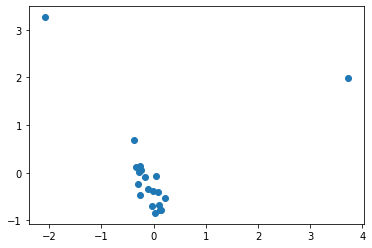

In [21]:
plt.scatter(X_pca[:,0],X_pca[:,1])

PCA를 이용한 차원 축소(2차원으로)

In [7]:
from sklearn.decomposition import PCA
audio1=preProcess("C:/ffmpeg/bin/input/Ariana Grande - God is a woman(0).wav")
audio1

array([[ 1.29220509e-02,  4.58524385e-02,  7.29470613e-02, ...,
         6.41934139e-02,  1.01709045e-01,  1.11296373e-01],
       [ 1.68405294e-07,  1.68828725e-06,  8.68882948e-06, ...,
         1.41530399e-02,  1.02525848e-02,  9.88193931e-03],
       [ 1.40152361e+00,  2.17908233e+00,  2.87793427e+00, ...,
         3.23120627e+00,  3.20609806e+00,  3.17619638e+00],
       ...,
       [ 0.00000000e+00, -5.26418452e-03,  8.63868040e-04, ...,
         8.15826621e-03, -8.90042189e-03,  9.41465322e-03],
       [ 0.00000000e+00,  1.24947917e-04, -2.85406077e-04, ...,
         1.54440933e-02, -1.62195712e-02,  3.77722041e-03],
       [ 0.00000000e+00, -5.45032785e-03,  8.41603210e-03, ...,
        -7.58835624e-03, -9.09631053e-04, -2.77007362e-03]])

In [8]:
pca=PCA(n_components=2,whiten=True)
pca.fit(audio1)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

In [9]:
audio1_pca=pca.fit_transform(audio1)
audio1_pca=audio1_pca[22:34]
print(audio1_pca)

[[-0.09191698 -0.26961369]
 [-0.09363707 -0.21814561]
 [-0.09689809 -0.16253268]
 [-0.10325297 -0.09643093]
 [-0.11289722 -0.4310286 ]
 [-0.09765987 -0.26267813]
 [-0.09230278 -0.2495424 ]
 [-0.09720021 -0.21282307]
 [-0.09583184 -0.21467231]
 [-0.09264962 -0.2386617 ]
 [-0.0932768  -0.28702272]
 [-0.1000175  -0.26897689]]


In [37]:
#fileList = []
filePath="C:/ffmpeg/bin/input/"
for root, dirs, filenames in os.walk(filePath):
    for file in filenames:
        x=preProcess(filePath+file)
        pca = PCA(n_components=2)
        pca.fit(x)
        x_pca = pca.fit_transform(x)
        print(str(file)+","+str(x_pca))

Ariana Grande - God is a woman(0).wav,[-4.09948596 -0.3254343 ]
Ariana Grande - God is a woman(1).wav,[-3.82410832 -0.13890285]
Ariana Grande - God is a woman(10).wav,[-3.2387247e+00 -3.0858145e-03]
Ariana Grande - God is a woman(11).wav,[-3.23497665 -0.01741393]
Ariana Grande - God is a woman(12).wav,[-3.78055308 -0.21855498]
Ariana Grande - God is a woman(13).wav,[-3.58595996  0.17399683]
Ariana Grande - God is a woman(14).wav,[-3.6375145  -0.27845851]
Ariana Grande - God is a woman(15).wav,[-3.62267224e+00  5.03854390e-04]
Ariana Grande - God is a woman(16).wav,[-3.79259781  0.23312148]
Ariana Grande - God is a woman(17).wav,[-3.59401943 -0.37932518]
Ariana Grande - God is a woman(18).wav,[-3.63383907 -0.36712836]
Ariana Grande - God is a woman(19).wav,[-3.53889392 -0.37084578]
Ariana Grande - God is a woman(2).wav,[-3.63792266 -0.4045209 ]
Ariana Grande - God is a woman(20).wav,[-4.0493228  -0.38786465]
Ariana Grande - God is a woman(21).wav,[-3.73586002 -0.23209553]
Ariana Grande 

Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(12).wav,[-4.37591522 -0.35193483]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(13).wav,[-4.05367745 -0.31876168]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(14).wav,[-4.35610534  0.65571557]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(15).wav,[-4.04692118  0.09361296]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(16).wav,[-3.9901378  -0.06658104]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(17).wav,[-4.55480515 -0.34768906]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(18).wav,[-3.45039286 -0.42326259]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(19).wav,[-3.77752188 -0.54222209]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(2).wav,[-4.15784192  0.43768202]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(20).wav,[-3.63256222 -0.47813961]
Dawin - Dessert _ Spella Waacking Choreography-g3DlYedzfjg(21).wav,[-3.

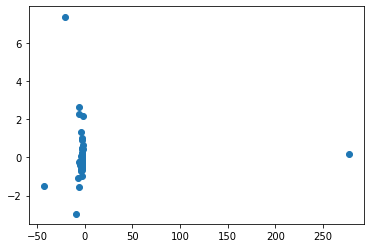

In [48]:
plt.scatter(x_pca[:,0], x_pca[:,1])

In [45]:
print(x_pca.explained_variance_ratio_)

AttributeError: 'numpy.ndarray' object has no attribute 'explained_variance_ratio_'

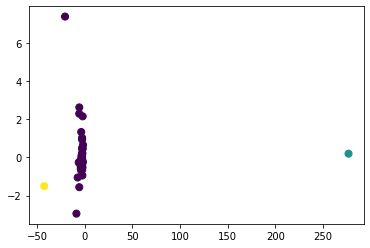

In [44]:
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=label,
            s=50, cmap='viridis');

Visualization(시각화)

NameError: name 'x_pca' is not defined

In [22]:
data = getDataset("C:/ffmpeg/bin/input/")

In [23]:
data

,G#,G,F#,F,E,D#,D,C#,C,B,A#,A
0,0.031447,0.000000,0.000000,0.100629,0.238994,0.408805,0.069182,0.000000,0.062893,0.069182,0.006289,0.012579
1,0.069182,0.000000,0.044025,0.088050,0.264151,0.056604,0.113208,0.000000,0.163522,0.169811,0.025157,0.006289
2,0.767296,0.000000,0.000000,0.000000,0.000000,0.000000,0.226415,0.000000,0.000000,0.000000,0.000000,0.006289
3,0.371069,0.000000,0.000000,0.000000,0.000000,0.000000,0.025157,0.000000,0.000000,0.000000,0.000000,0.603774
4,0.088050,0.018868,0.144654,0.000000,0.000000,0.245283,0.113208,0.006289,0.075472,0.163522,0.132075,0.012579
...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.295597,0.031447,0.245283,0.069182,0.000000,0.075472,0.069182,0.000000,0.044025,0.106918,0.031447,0.031447
176,0.031447,0.012579,0.069182,0.018868,0.044025,0.037736,0.169811,0.031447,0.132075,0.314465,0.132075,0.006289
177,0.006289,0.006289,0.213836,0.018868,0.056604,0.012579,0.295597,0.012579,0.018868,0.037736,0.295597,0.025157
178,0.018868,0.006289,0.138365,0.006289,0.056604,0.075472,0.364780,0.050314,0.000000,0.006289,0.264151,0.012579


In [52]:
from sklearn.cluster import KMeans
n_clusters=4
model = KMeans(n_clusters)
model.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [53]:
model.predict(data)

array([2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 0, 0, 3, 2, 2, 0, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 2, 1, 2, 0, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 2, 0, 0, 0, 1, 1, 2,
       0, 0, 1, 1, 0, 1, 2, 1, 2, 1, 0, 0, 1, 0, 1, 1, 2, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1,
       1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 3, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 0, 3, 2, 2, 2, 2, 2, 1, 2, 1, 1, 3, 0, 2, 2, 2, 2,
       2, 1, 1, 1])

In [54]:
print (model.inertia_)

14.10274730068024


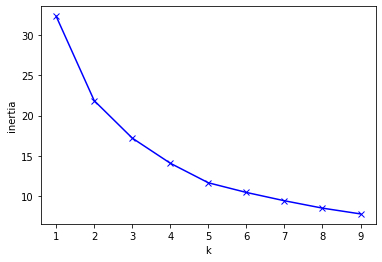

In [59]:
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data)
    kmeanModel.fit(data)
    inertia.append(kmeanModel.inertia_)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

In [27]:
k = 3
epochs = 1000

In [28]:
def initilizeCentroids( data, k ):

    centroids = data[ 0: k ] #A
    
    return centroids

In [29]:
tf.compat.v1.disable_eager_execution()
X = tf.compat.v1.placeholder( dtype = tf.float32 )
C = tf.compat.v1.placeholder( dtype = tf.float32 )
C_labels = tf.compat.v1.placeholder( dtype = tf.int32 )

In [30]:
# utility to assign centroids to examples
expanded_vectors = tf.expand_dims( X, 0 )
expanded_centroids = tf.expand_dims( C, 1 )
distance = tf.reduce_sum( tf.square( tf.subtract( expanded_vectors, expanded_centroids ) ), axis = 2 )
getCentroidsOp = tf.argmin( distance, 0 )


# utility to recalculate centroids
sums = tf.math.unsorted_segment_sum( X, C_labels, k )
counts = tf.math.unsorted_segment_sum( tf.ones_like( X ), C_labels, k  )
reCalculateCentroidsOp = tf.math.divide( sums,  counts )

In [31]:
centroids = []
data_labels = []

with tf.compat.v1.Session() as sess:

    # Initilize all tensor flow variables
    sess.run( tf.compat.v1.global_variables_initializer() )

    # Get initial list of k centroids
    centroids = initilizeCentroids( data, k )

    for epoch in range( epochs ):
        data_labels =  sess.run( getCentroidsOp, feed_dict = { X: data, C: centroids } )
        centroids = sess.run( reCalculateCentroidsOp, feed_dict = { X: data, C_labels: data_labels } )

print( data_labels )
print( centroids )

[0 0 2 2 0 0 0 0 0 0 0 1 1 2 0 1 1 2 2 2 2 2 2 2 2 2 1 1 0 1 0 0 0 0 2 2 2
 1 2 2 2 2 1 2 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 1 1 0 1 2
 1 0 0 0 0 0 0 1 0 1 1 1 2 0 0 0 0 0 1 0 1 1 2 1 0 0 0 0 0 1 1 1]
[[1.4684030e-01 2.1306632e-02 6.2457528e-02 4.6930984e-02 6.9131881e-02
  1.3829957e-01 8.4199719e-02 6.2893089e-03 6.7257099e-02 1.8258564e-01
  1.2328225e-01 5.1419135e-02]
 [4.8561934e-02 2.0396171e-02 1.6792881e-01 1.5188079e-02 8.3112925e-02
  3.3101618e-02 2.8548142e-01 7.7411406e-02 1.8337373e-02 4.1800857e-02
  1.5720484e-01 5.1474590e-02]
 [7.1081203e-01 0.0000000e+00 1.5723271e-03 8.1236903e-03 2.6205450e-04
  3.4067088e-03 6.5628283e-02 2.6205450e-04 0.0000000e+00 9.4339624e-03
  4.9790354e-03 1.9551998e-01]]


In [32]:
final_labels = pd.DataFrame( { "Labels": data_labels, "File Names": fileList } )
final_labels

,Labels,File Names
0,0,Ariana Grande - God is a woman(0).wav
1,0,Ariana Grande - God is a woman(1).wav
2,2,Ariana Grande - God is a woman(10).wav
3,2,Ariana Grande - God is a woman(11).wav
4,0,Ariana Grande - God is a woman(12).wav
...,...,...
175,0,Dawin - Dessert _ Spella Waacking Choreography...
176,0,Dawin - Dessert _ Spella Waacking Choreography...
177,1,Dawin - Dessert _ Spella Waacking Choreography...
178,1,Dawin - Dessert _ Spella Waacking Choreography...
